# Figure 8 — Variations in gain

In [1]:
include("src/model.jl")
include("src/serialdep.jl")
include("src/quantile_stats.jl")
include("src/pyplot.jl");

## 1. Load data (Barbosa 2020)

In [2]:
# load Barbosa dataset
barbosa_dir = "../data/Barbosa20IR/interplayPFC/Data"

behavior_sessions = read_pickle_windows(barbosa_dir * "/monkey_behavior_by_sessions.pickle") 
behavior_neurons  = read_pickle_windows(barbosa_dir * "/monkey_behavior_by_neuron.pickle")
neural            = read_pickle_windows(barbosa_dir * "/neural_data_concat.pickle");

In [3]:
nneurons = length(neural)
ncues = 8
ri = (0.0, 3.5)

df_exp = DataFrame()

for n in 1:nneurons
    # load as in Barbosa code
    # https://github.com/comptelab/interplayPFC
    session = behavior_neurons[n]["session"]
    dict = behavior_sessions[session]

    # add 1 to indices (Python indexing -> Julia)
    idx_cur = dict["i_close_trials"] .+ 1
    idx_pre = dict["i_prev_trials"] .+ 1
    
    @assert length(idx_cur) == length(idx_pre)

    trials_cur = dict["trials"][idx_cur,:]
    trials_pre = dict["trials"][idx_pre,:]

    report_cur = dict["report"][idx_cur]
    report_pre = dict["report"][idx_pre]

    # require fixation longer than 1.7s, as in Barbosa code
    fixations = behavior_neurons[n]["INDX"][idx_pre, 3+1] .- behavior_neurons[n]["INDX"][idx_pre, 4+1]
    idx_valid = fixations .> -1700
    
    # put raw values in DataFrame
    df = DataFrame()
    
    # cues
    df.cue_cur = round.(Int, trials_cur[idx_valid, 1])
    df.cue_pre = round.(Int, trials_pre[idx_valid, 1])
    
    # stimuli
    df.stimulus_cur = (df.cue_cur .- 1) ./ ncues .* 2π
    df.stimulus_pre = (df.cue_pre .- 1) ./ ncues .* 2π
    
    # reports
    df.report_cur = report_cur[idx_valid]
    df.report_pre = report_pre[idx_valid]
    
    # errors
    df.error_cur = cdist.(df.report_cur, df.stimulus_cur)
    df.error_pre = cdist.(df.report_pre, df.stimulus_pre)
    
    # auxilliary variables
    df.n = fill(n, nrow(df))
    df.session = fill(session, nrow(df))
    df.trial = trials_cur[idx_valid, 3]
    
    # mean report for cue    
    # session_cues = dict["trials"][:,1]
    # session_reports = dict["report"]
    # mean_report = [cmean(session_reports[session_cues .== c]) for c in 1:ncues]
    # df.mean_report = mean_report[df.cue_cur]
    
    # spikes during RI
    spikes = neural[n][idx_valid, :]
    df.spikes = sum(ri[1] .< spikes .< ri[2], dims=2) |> vec
    
    append!(df_exp, df)
end

# map stimuli and reports to [-π, π]
cols = [:stimulus_cur, :stimulus_pre, :report_cur, :report_pre]
transform!(df_exp, cols .=> (v -> cdist.(v, 0)) .=> cols)

# use mean report instead of stimulus
# df_exp.error_cur = cdist.(df_exp.report_cur, df_exp.stimulus_cur) # mean_report_cur

df_exp = combine(groupby(df_exp, :n)) do gdf
    if length(unique(gdf.cue_cur)) == ncues # > 4
        return gdf
    else
        return DataFrame()
    end
end

first(df_exp, 3)

,n,cue_cur,cue_pre,stimulus_cur,stimulus_pre,report_cur,report_pre,error_cur
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,2,6,1,-2.35619,0.0,-2.72904,0.00919937,-0.372845
2,2,2,6,0.785398,-2.35619,0.781792,-2.72904,-0.00360637
3,2,3,7,1.5708,-1.5708,1.42634,-1.88921,-0.144454


In [4]:
sessions = unique(collect(df_exp.session));

## 2. Behavioral analysis

### 2.1 Quantile stats

In [5]:
# compute difference in error from previous trial to current trial
df_exp.error_cur_sq = df_exp.error_cur .^ 2
df_exp.error_pre_sq = df_exp.error_pre .^ 2
df_exp.error_diff = df_exp.error_cur_sq .- df_exp.error_pre_sq

# compute average error_diff based error_pre quantiles
#quantiles = @df df_exp quantile_stats(:error_diff, :error_pre_sq; q=6)
df_quantiles = @df df_exp quantile_stats(:error_cur_sq, :error_pre_sq; q=6);

### 2.2 Regression

In [6]:
using GLM, MixedModels, CategoricalArrays

In [7]:
df_regression = @select(
    df_exp,
    # make session a categorical variable for random effects
    :session = categorical(:session),
    :error_cur_sq,
    :error_diff,
    # indicator is 1 if the previous error was larger than average, -1 otherwise
    :indicator = 2 .* (:error_pre_sq .> mean(:error_pre_sq)) .- 1,
);

In [8]:
model = fit(MixedModel, @formula(error_cur_sq ~ 1 + indicator + (1 | session)), df_regression)
show(model)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\antho\.julia\packages\ProgressMeter\Vf8un\src\ProgressMeter.jl:620
Minimizing 21 	 Time: 0:00:00 (18.38 ms/it)


Linear mixed model fit by maximum likelihood
 error_cur_sq ~ 1 + indicator + (1 | session)
    logLik   -2 logLik      AIC         AICc        BIC     
   8910.5090 -17821.0181 -17813.0181 -17813.0114 -17786.2454

Variance components:
            Column    Variance  Std.Dev. 
session  (Intercept)  0.0000648 0.0080491
Residual              0.0029156 0.0539967
 Number of obs: 5962; levels of grouping factors: 60

  Fixed-effects parameters:
──────────────────────────────────────────────────────
                   Coef.   Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────────
(Intercept)   0.0290184   0.0013596    21.34    <1e-99
indicator    -0.00520557  0.000776576  -6.70    <1e-10
──────────────────────────────────────────────────────

## 3. Neural analysis

### 3.1 Fit preferred stimulus for each neuron

In [9]:
using LsqFit

# neuron tuning curve, A exp(w⁻¹ (cos(θ - ϕ) - 1))
tuning_curve(x, p) = p[1] .* exp.(1/p[2] .* (cos.(cdist.(x, p[3])) .- 1))

function fit_tuning_curve(θ, μ)    
    # bounds: A and w have to be positive, no restriction on ϕ
    lb = [0.0, 0.0, -Inf]
    ub = [Inf, 50.0, Inf]
    p0 = [mean(μ), 1.0, 0.0]
    
    # fit tuning curve to mean spike count for each stimulus
    fit = curve_fit(tuning_curve, θ, μ, p0, lower=lb, upper=ub)
    A, w, ϕ = fit.param
    
    # bring ϕ in range [-π, π] since we didn't set any bounds
    return A, w, rem2pi(ϕ, RoundNearest)
end
fit_tuning_curve(df::AbstractDataFrame) = @chain df begin
    # compute mean number of spikes for each stimulus
    @by(:cue_cur, :μ = mean(:spikes), :θ = first(:stimulus_cur))
    
    # fit tuning curve to mean spikes for each stimulus
    @df fit_tuning_curve(:θ, :μ)
end
;

In [10]:
Random.seed!(4242)

# add fitted ϕ
@chain df_exp begin
    # fit tuning curve independently for each neuron
    groupby(:n)
    
    # fit tuning curve
    @transform! @astable begin
        # collect cols into DataFrame to fit curve
        df = DataFrame(cue_cur=:cue_cur, stimulus_cur=:stimulus_cur, spikes=:spikes)
        A, w, ϕ = fit_tuning_curve(df)
        
        # create new columns
        :ϕ = ϕ
        :fit_A = A
        :fit_w = w
    end
    
    # compute distortion
    @transform! :D = -cos.(cdist.(:ϕ, :stimulus_cur))
end
;

In [11]:
# get df for example
df = @subset(df_exp, :n .== 66)

# get fitted params
fitted_params = [df.fit_A[1], df.fit_w[1], df.ϕ[1]]

df_tuning = @chain df begin
    # compute mean number of spikes for each stimulus
    @by(
        :cue_cur,
        :μ = mean(:spikes),
        :stderr = stde(:spikes),
        :θ = first(:stimulus_cur),
    )
    
    # sort by stimulus
    @orderby(:θ)
    
    # duplicate last stimulus
    @aside begin
        lastrow = DataFrame(last(_))
        lastrow.cue_cur .= 0
        lastrow.θ .= -π
    end
    
    # add last stimulus as first
    append!(lastrow)
    
    # sort again to put added row into correct place
    @orderby(:θ)
end;

### 3.2 Perform Poisson regression to infer β

In [12]:
function get_steps_and_avg_interpolation(df; n=5)
    # compute spikes per trial
    spikes = [gdf.spikes for gdf in groupby(df, :n)]    
    spikes = hcat(spikes...)
    
    # compute number of non-recorded trials between each recorded trial
    trials = first(groupby(df, :n)).trial
    steps = vcat(Int.(diff(trials)), 1) # add trailing 1 for final trial
    
    # create matrix with mean spike count, then replace with 
    # actual spike count at recorded trials
    # -> smoother exponential moving average
    avg = zeros(sum(steps), size(spikes, 2))
    avg_idx = vcat(1, 1 .+ cumsum(steps)[1:end-1])
    avg[avg_idx,:] = spikes
    
    for (start, stop) in zip(avg_idx[1:end-1], avg_idx[2:end])
        nvals = stop - start + 1
        vals = LinRange(avg[start,:], avg[stop,:], nvals)[2:end-1] |> collect
        vals = hcat(vals...)'
        
        avg[start + 1 : stop - 1, :] = vals
    end
    
    # compute exponential average and shift back one position
    avg = exp_moving_avg(avg, n, vec(mean(spikes, dims=1)))
    avg = [mean(spikes, dims=1); avg[1:end-1,:]]
    
    # keep avg at positions with recorded trials
    avg = avg[avg_idx,:]
    
    return steps, avg
end;

### Get regression betas

In [13]:
βneuron = Dict()
bics = DataFrame()

for neuron in unique(df_exp.n)
    df = @subset(df_exp, :n .== neuron)
    nneurons = 1
    
    steps, avg = get_steps_and_avg_interpolation(df; n=5)    

    μ = mean(df.spikes, dims=1)
    μ = repeat(μ, nrow(df)) |> vec
    μ = log.(nneurons .* μ)
    df.μ = μ
    
    df.avg = log.(avg) |> vec

    ols = glm(@formula(spikes ~ -D + avg), df, Poisson(), LogLink())#, offset=μ)
    ols_no_avg = glm(@formula(spikes ~ -D), df, Poisson(), LogLink())#, offset=μ)
    ols_no_avg_no_d = glm(@formula(spikes ~ 1), df, Poisson(), LogLink())#, offset=μ)
    
    β = coef(ols)[2]
    if β > 0
        βneuron[neuron] = β
        
        append!(
            bics,
            DataFrame(
                n=neuron,
                bic=bic(ols),
                bic_no_avg=bic(ols_no_avg),
                bic_no_avg_no_d=bic(ols_no_avg_no_d)
            ),
        )
    end
    #βneuron[neuron] = β > 0 ? β : 0
end

In [14]:
combine(bics, [:bic, :bic_no_avg, :bic_no_avg_no_d] .=> sum)

,bic_sum,bic_no_avg_sum,bic_no_avg_no_d_sum
,Float64,Float64,Float64
1,54544.5,59162.9,67903.7


In [15]:
df_neuron = @pipe combine(groupby(df_exp, :n)) do gdf
    neuron = gdf.n[1]
    
    if !(neuron in keys(βneuron))
        return DataFrame()
    else
        w = first(gdf.fit_w)
        
        error_sq = gdf.error_cur_sq |> mean
        
        β = βneuron[neuron]
        
        return DataFrame(error_sq = error_sq, β = β, w = 1/w, session = gdf.session[1])
    end        
end |> sort(_, :β)

# remove outlier
filter!(:β => <(2), df_neuron)

# get df with mean fitted beta 
df_session_mean = combine(
    groupby(df_neuron, :session),
    :β => mean => :β,
    :error_sq => first => :error_sq,
);

In [16]:
using RCall

function regression_test(x, y)
    result = R"cor.test($x, $y, method='pearson')"
    return rcopy(result)
end

function ranked_regression_test(x, y)
    result = R"cor.test($x, $y, method='spearman')"
    return rcopy(result)
end;

In [20]:
reg_test = @df df_session_mean regression_test(:β, :error_sq)
reg_pval = round(reg_test[:p_value], digits=3)
reg_r    = round(reg_test[:estimate], digits=2)

ranked_reg_test = @df df_session_mean ranked_regression_test(:β, :error_sq)
ranked_reg_pval = round(ranked_reg_test[:p_value], digits=3)
ranked_reg_r    = round(ranked_reg_test[:estimate], digits=2)

println("regression: pval = $reg_pval, r = $reg_r")
println("ranked regression: pval = $ranked_reg_pval, r = $ranked_reg_r")
println()

regression: pval = 0.014, r = -0.32
ranked regression: pval = 0.033, r = -0.28



## 4. Final figure

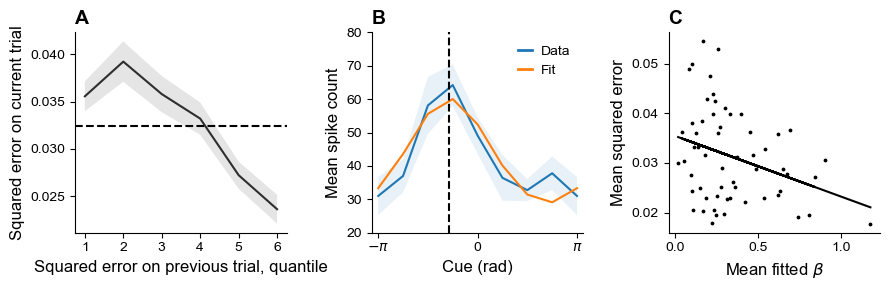

In [27]:
fig = figure("fig7_systemicbiases", figsize=(9, 3))

# A: Quantiles
ax = subplot(131)
plt.title("A")

# plot quantile stats
@df df_quantiles ax.plot(:q, :μ, color="k", alpha=0.8)
@df df_quantiles ax.fill_between(:q, :μ .- :se, :μ .+ :se, facecolor="k", edgecolor="none", alpha=0.1)

ax.axhline(y = mean(df_exp.error_cur_sq), color = "k", linestyle = "--")

ax.set_xticks(df_quantiles.q)

ax.set_xlabel("Squared error on previous trial, quantile")
ax.set_ylabel("Squared error on current trial")

# B: Tuning
ax = subplot(132)
plt.title("B")

# data
@df df_tuning ax.plot(:θ, :μ, label="Data", color=get_palette(1))
@df df_tuning ax.fill_between(:θ, :μ .- :stderr, :μ .+ :stderr, facecolor=get_palette(1), edgecolor="none", alpha=0.1)
# fit
@df df_tuning ax.plot(:θ, tuning_curve(:θ, fitted_params), label="Fit", color=get_palette(2))

ax.axvline(x = fitted_params[3], color = "k", linestyle = "--")

ax.set_xlim(-π-0.2, π+0.2)
ax.set_xticks([-π, 0, π])
ax.set_xticklabels([L"-\pi", "0", L"\pi"])

ax.set_ylim(20, 80)

ax.set_xlabel("Cue (rad)")
ax.set_ylabel("Mean spike count")

legend() |> legend_shorten_lines!

# C: gain parameter
ax = subplot(133)
plt.title("C")

ols = lm(@formula(error_sq ~ 1 + β), df_session_mean)

@df df_session_mean ax.scatter(:β, :error_sq; color = "k", s=3,)
@df df_session_mean ax.plot(:β, predict(ols, df_session_mean); color= "k",)
    
ax.set_xlabel(L"Mean fitted $\beta$")
ax.set_ylabel("Mean squared error")

# Update the figure
fig.tight_layout(w_pad=2, rect=(0, 0, 1, 1)) # (left, bottom, right, top)

In [28]:
fig.savefig("figs/fig8_gainvariations.pdf");

## Utils

#### Plot fitted ϕ for each neuron

In [ ]:
pyplot()

# plot all
plots = []

for n in unique(df_exp.n)
    df = @subset(df_exp, :n .== n)

    # get fitted params
    fitted_params = [df.fit_A[1], df.fit_w[1], df.ϕ[1]]
    
    df = @chain df begin
        # compute mean number of spikes for each stimulus
        @by(
            :cue_cur,
            :μ = mean(:spikes),
            :stderr = stde(:spikes),
            :θ = first(:stimulus_cur),
        )

        # sort by stimulus
        @orderby(:θ)

        # duplicate last stimulus
        @aside begin
            lastrow = DataFrame(last(_))
            lastrow.cue_cur .= 0
            lastrow.θ .= -π
        end

        # add last stimulus as first
        append!(_, lastrow)

        # sort again to put added row into correct place
        @orderby(:θ)
    end

    plot_tuning = @df df plot(
        :θ,
        :μ,
        ribbon=:stderr,
        label="",
        ylim=(0, Inf),
        size=(400, 400),
        color=2,
        linewidth=2,
    )
    @df df plot!(
        :θ,
        tuning_curve(:θ, fitted_params),
        label="",
        color=1,
        linewidth=2,
        title=string(n)
    )
    
    push!(plots, plot_tuning)
end

# add blank plots to get even number
append!(plots, fill(plot_blank(), 3));

plot(plots..., layout=(25, 5), size=(1000, 5000))

#### Plot β per neuron

In [ ]:
pyplot();

plots = []
for gdf in groupby(df_neuron, :session)
    if nrow(gdf) > 1
        push!(plots, plot(gdf.β, title="β", ylim=(0, 2)))
    end
end

plot(plots..., layout=(9, 4), size=(800, 1600))

## Turing

In [ ]:
using Turing, StatsPlots, Random
using Optim

#### Compare result of regular regression and Turing

In [ ]:
using Logging

In [ ]:
# Bayesian poisson regression (LR)
@model function poisson_regression(spikes, D, avg, μ, σ²)
    I ~ Normal(0, σ²)
    β ~ TruncatedNormal(5, σ², 0, 200)
    w ~ Normal(0, σ²)
    
    @. spikes ~ Poisson(exp(I + μ - β * D + w * avg))
end

@model function poisson_regression_no_w(spikes, D, μ, σ²)
    I ~ Normal(0, σ²)
    β ~ TruncatedNormal(5, σ², 0, 200)
    
    @. spikes ~ Poisson(exp(I + μ - β * D))
end

@model function poisson_regression_empty(spikes, μ, σ²)
    I ~ Normal(0, σ²)
    
    @. spikes ~ Poisson(exp(I + μ))
end

sample_quiet(model; nsamples=10_000, nthreads=Threads.nthreads()) = with_logger(NullLogger()) do
    sample(model, NUTS(200, 0.65), MCMCThreads(), nsamples, nthreads)
end;

In [ ]:
model = @df df poisson_regression(:spikes, :D, :avg, :μ, 10)
model_no_w = @df df poisson_regression_no_w(:spikes, :D, :μ, 10)
model_empty = @df df poisson_regression_empty(:spikes, :μ, 10);

In [ ]:
chain = sample_quiet(model)
chain_no_w = sample_quiet(model_no_w)
chain_empty = sample_quiet(model_empty);

In [ ]:
for (c, o) in zip([chain, chain_no_w, chain_empty], [ols, ols_no_w, ols_empty])
    sum((DataFrame(mean(c)).mean .- coef(o)) .^ 2) |> println
end

In [ ]:
#mle_estimate = optimize(model, MLE(), NelderMead(), Optim.Options(iterations=30_000))
#map_estimate = optimize(model, MAP(), NelderMead(), Optim.Options(iterations=30_000))

#### Compute log marginal likelihood using bridge sampling

In [ ]:
using BridgeSampling

In [ ]:
L1 = bridgesampling(chain, model)
L2 = bridgesampling(chain_no_w, model_no_w)
L3 = bridgesampling(chain_empty, model_empty)

likelihoods = [L1, L2, L3];

In [ ]:
value.([L1, L2, L3])

In [ ]:
map(error_estimate, likelihoods)

In [ ]:
exp.(value.(likelihoods) .- logsumexp(value.(likelihoods)))

In [ ]:
likelihoods = DataFrame()

for (i, session) in enumerate(sessions)
    lg("$session ($i / $(length(sessions)))")
    
    df = filter(:session => ==(session), df_exp)
    nneurons = length(unique(df.n))
    
    steps, avg = get_steps_and_avg(df)

    df.avg = log.(avg) |> vec

    μ = mean(df.spikes, dims=1)
    μ = repeat(μ, nrow(df)) |> vec
    μ = log.(nneurons .* μ)
    df.μ = μ
    
    model = @df df poisson_regression(:spikes, :D, :avg, :μ, 10)
    model_no_w = @df df poisson_regression_no_w(:spikes, :D, :μ, 10)
    model_empty = @df df poisson_regression_empty(:spikes, :μ, 10)
    
    chain1 = sample_quiet(model)
    chain2 = sample_quiet(model_no_w)
    chain3 = sample_quiet(model_empty)
    
    L1 = bridgesampling(chain1, model)
    L2 = bridgesampling(chain2, model_no_w)
    L3 = bridgesampling(chain3, model_empty)
    
    I, β, w = DataFrame(mean(chain1)).mean
    I2, β2 = DataFrame(mean(chain2)).mean
    I3 = DataFrame(mean(chain3)).mean[1]
    
    append!(likelihoods, DataFrame(session=session, L1=L1, L2=L2, L3=L3, β=β, I=I, w=w, I2=I2, β2=β2, I3=I3))
end

In [ ]:
intervals = Dict(
    "prev_stimulus" => [-6.6, -6.1],
    "prev_delay"    => [-6.1, -3.1],
    "prev_ri"       => [-6.6, -3.1],
    "prev_report"   => [-3.1, -2.75],
    "iti"           => [-3.1,  0.0],
    "stimulus"      => [ 0.0,  0.5],
    "delay"         => [ 0.5,  3.5],
    "ri"            => [ 0.0,  3.5],
    "report"        => [ 3.5,  3.85],
    "trial"         => [-3.1,  3.5],
    "trial_pre"     => [-6.6,  0.0],
)

intervals_win = [-6.6, 3.85]